In [280]:
import networkx as nx
import matplotlib.pyplot as plt
from gurobipy import *

# Question 1_b

# Method 1: nx.shortest_path

In [281]:
## Define the edges and their weights. Because the duration belongs to the nodes, instead of the edges, 
## I must transfer the duration to the weight inside the edges first.
## I create a duplicate mimic node to storage the duration. For example, the node1 will do a mitosis:
## creating two nodes: node1 and node2. node1 will inherit the original node1 and connect to node2
## the edges of node1 to node2 will create a weight that is the same as the node's duration.
G=nx.Graph()
G.add_edge(0,  1, weight= 0)
G.add_edge(1,  2, weight= 8)
G.add_edge(2,  3, weight= 0)
G.add_edge(2,  5, weight= 0)
G.add_edge(3,  4, weight= 4)
G.add_edge(4,  7, weight= 0)
G.add_edge(4,  9, weight= 0)
G.add_edge(5,  6, weight= 3)
G.add_edge(6, 11, weight= 0)
G.add_edge(7,  8, weight=10)
G.add_edge(8, 13, weight= 0)
G.add_edge(9, 10, weight= 5)
G.add_edge(10,13, weight= 0)
G.add_edge(11,12, weight= 4)
G.add_edge(12,13, weight= 0)
G.add_edge(13,14, weight= 3)
G.add_edge(14,15, weight= 0)

In [282]:
## Check purposes only.
for (i,j,d) in G.edges(data=True): 
    print(i,j,d)

0 1 {'weight': 0}
1 2 {'weight': 8}
2 3 {'weight': 0}
2 5 {'weight': 0}
3 4 {'weight': 4}
5 6 {'weight': 3}
4 7 {'weight': 0}
4 9 {'weight': 0}
7 8 {'weight': 10}
9 10 {'weight': 5}
6 11 {'weight': 0}
11 12 {'weight': 4}
8 13 {'weight': 0}
13 10 {'weight': 0}
13 12 {'weight': 0}
13 14 {'weight': 3}
14 15 {'weight': 0}


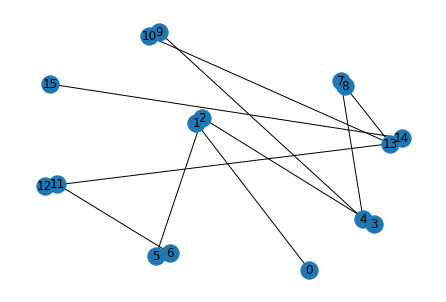

In [283]:
## We can also plot the network.
nx.draw(G, with_labels=True)

In [284]:
source= 0
terminal=15

## Get the answer use the function to compute the data.
print(nx.shortest_path(G, source, terminal, weight='weight')) # get the answer directly
print(nx.shortest_path_length(G, source, terminal, weight='weight'))

[0, 1, 2, 5, 6, 11, 12, 13, 14, 15]
18


# Method 2: LP_1
![1.b_1](Figures/1.b_1.png)

In [434]:
## Compared to the previous one, I do not need to do a mitosis. Because the duration don't belong to 
## specific one node, I can put duration into edge as a weight.
H=nx.DiGraph()
H.add_edge(0,  1)
H.add_edge(1,  2)
H.add_edge(1,  3)
H.add_edge(2,  4)
H.add_edge(2,  5)
H.add_edge(4,  7)
H.add_edge(5,  7)
H.add_edge(3,  4)
H.add_edge(3,  6)
H.add_edge(6,  7)
H.add_edge(7,  8)

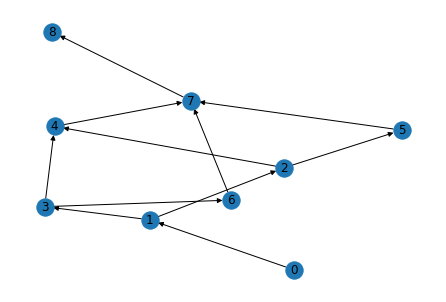

In [435]:
## We can also plot the network.
nx.draw(H, with_labels=True)

In [436]:
model_2=Model("question1.b")

In [437]:
## define variables at each edges: x[i,j]
x={}
for (i,j) in H.edges():
    x[i,j]=model_2.addVar(vtype=GRB.BINARY, name='x('+str(i)+','+str(j)+')') 

In [438]:
## Define source, terminal, weight
source = 0
terminal = 8
weight = [0,8,4,3,10,5,4,3,0]

## Define a input and output flow at edge node
inc={}
out={}
for i in H.nodes():
    inc[i]=0 ## define the start value is 0
    out[i]=0 ## define the end value is 0
    
for (i,j) in H.edges():
    inc[j]+=x[i,j] ## the output flow of the previous nodes combination is the input flow of the node
    out[i]+=x[i,j] ## the output flow of the node 
    

    
for i in H.nodes(): 
    if i==source:
        model_2.addConstr(out[i]-inc[i]==1) ## the source node has a flow equals to 1 (only an input flow)
    elif i==terminal:
        model_2.addConstr(out[i]-inc[i]==-1) ## the terminal node has a flow equals to -1 (only an output flow)
    else:
        model_2.addConstr(out[i]-inc[i]==0) ## all nodes in the middle will have a balanced flow = 0

In [439]:
obj_2 = 0
for i in range(len(inc)):
    obj_2 += (weight[i])*inc[i] ## Create a minimum function that equals to the input of 
                              ## the node multipy by the weight of this node

model_2.setObjective(obj_2, GRB.MINIMIZE)

In [440]:
model_2.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 9 rows, 11 columns and 22 nonzeros
Model fingerprint: 0xdc256c80
Variable types: 0 continuous, 11 integer (11 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 24.0000000
Presolve removed 9 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 18 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.800000000000e+01, best bound 1.800000000000e+01, gap 0.0000%


In [441]:
for (i,j,d) in H.edges(data=True):
    if x[i,j].X==1:
        print("(%s,%s): %2.1f"% (i,j, weight[j]))
        
print("The minimum cost is: {}".format(obj_2.getValue()))

(0,1): 8.0
(1,3): 3.0
(3,6): 4.0
(7,8): 0.0
(6,7): 3.0
The minimum cost is: 18.0


# Method 3: dual
![1.b_2](Figures/1.b_2.png)
![1.b_3](Figures/1.b_3.png)

In [340]:
## Create a dual model
model_dual=Model("question1.b_dual")

In [341]:
## create 7 + 2(node0 and node8) variables
y={}
for j in range(9):
    y[j]=model_dual.addVar(vtype=GRB.CONTINUOUS, name='y('+str(j)+')') 

In [364]:
weight = [0,8,4,3,10,5,4,3,0]

## Create contraints that the gap of two nodes that has an edge(y[i], y[i], y[i]-y[j]) 
## is less or equal to the cj
for (i,j) in H.edges():
    model_dual.addConstr(y[i]-y[j]<=weight[j], name='x('+str(i)+str(j)+')' )
print("How many constraint I get:")
model_dual.getConstrs()

How many constraint I get:


[<gurobi.Constr x(01)>,
 <gurobi.Constr x(12)>,
 <gurobi.Constr x(13)>,
 <gurobi.Constr x(24)>,
 <gurobi.Constr x(25)>,
 <gurobi.Constr x(34)>,
 <gurobi.Constr x(36)>,
 <gurobi.Constr x(47)>,
 <gurobi.Constr x(57)>,
 <gurobi.Constr x(78)>,
 <gurobi.Constr x(67)>]

In [366]:
obj_dual = y[0] - y[8] ## only the source and the terminal are not balanced; others will equal to 0.
model_dual.setObjective(obj_dual, GRB.MAXIMIZE)

model_dual.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 33 rows, 9 columns and 66 nonzeros
Model fingerprint: 0xadbb9caf
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
Presolve removed 29 rows and 5 columns
Presolve time: 0.00s
Presolved: 4 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+30   2.000000e+30   2.000000e+00      0s
       2    1.8000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.800000000e+01


In [367]:
for j in range(len(y)):
    print("(%s): %2.1f"% (j, y[j].X))
        
print("The minimum cost is: {}".format(obj_dual.getValue()))

(0): 18.0
(1): 10.0
(2): 8.0
(3): 7.0
(4): 3.0
(5): 3.0
(6): 3.0
(7): 0.0
(8): 0.0
The minimum cost is: 18.0


### Conclusion:
No matter I use the nx.shortest_path function, LP method, or daul to solve the problem, the results always points to the same minimum cost: **18 hours**.